In [11]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np

from dataset import SliceDataModule, SliceGrappaDataModule
from common.utils import save_reconstructions
from collections import defaultdict
from tqdm import tqdm
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
HASH = "398405734c9740ba8acee4a4602f1d60"
EPOCH = 3
SAVE_DIR = f"reconstructions/{HASH}"

In [14]:
from models import VarNetFreezedSensToyNAFNetOL as Model

checkpoint_path = None
if EPOCH is None:
    checkpoint_path = f"mlartifacts/0/{HASH}/artifacts/checkpoints/latest_checkpoint.pth"
else:
    checkpoint_path = f"mlartifacts/0/{HASH}/artifacts/checkpoints/epoch_{EPOCH}/checkpoint.pth"

checkpoint = torch.load(checkpoint_path)
hparams = checkpoint['hyper_parameters']
# Remove some keys that are not needed
del hparams["_class_path"]
del hparams["_instantiator"]
model = Model(**hparams)
model.load_state_dict(torch.load(checkpoint_path)["state_dict"])
model = model.cuda()

In [15]:
dm = SliceDataModule(root="/home/Data")
dm.setup("test")
dm.setup("predict")

In [16]:
work = {
    "public": dm.test_dataloader(),
    "private": dm.predict_dataloader()
}

model.eval()
with torch.no_grad():
    for phase, dataloader in work.items():
        reconstructions = defaultdict(dict)
        print(f"Reconstructing {phase} leaderboard...")
        for mask, kspace, target, maximum, fnames, slices in tqdm(dataloader):
            output = model(kspace.cuda(non_blocking=True), mask.cuda(non_blocking=True))
            output = model.image_space_crop(output)
            for i in range(output.shape[0]):
                reconstructions[fnames[i]][slices[i]] = output[i].cpu().numpy()

        for fname in reconstructions:
            reconstructions[fname] = np.stack(
                [reconstructions[fname][slice] for slice in sorted(reconstructions[fname])]
            )
        print(f"Saving reconstructions of {phase} leaderboard...")
        save_reconstructions(reconstructions, Path(f"{SAVE_DIR}/{phase}"))

Reconstructing public leaderboard...


  0%|          | 0/984 [00:00<?, ?it/s]

100%|██████████| 984/984 [02:37<00:00,  6.26it/s]


Saving reconstructions of public leaderboard...
Reconstructing private leaderboard...


100%|██████████| 984/984 [02:36<00:00,  6.29it/s]


Saving reconstructions of private leaderboard...


In [20]:
torch.save(model, "checkpoints/best_model.pt")

In [17]:
!sh leaderboard_eval.sh {HASH}

Model: 398405734c9740ba8acee4a4602f1d60

Leaderboard SSIM : 0.9668
========== Details ==========
Leaderboard SSIM (public): 0.9802
Leaderboard SSIM (private): 0.9534


In [18]:
hparams

{'sens_net_path': 'checkpoints/good_sens_net.pth',
 'num_processors': 2,
 'num_cascades': 8,
 'chans': 18,
 'pools': 4,
 'nafnet_width': 32,
 'nafnet_enc_blk_nums': [2, 2, 4, 8],
 'nafnet_middle_blk_num': 12,
 'nafnet_dec_blk_nums': [2, 2, 2, 2]}

TypeError: Invalid shape (1, 384, 384) for image data

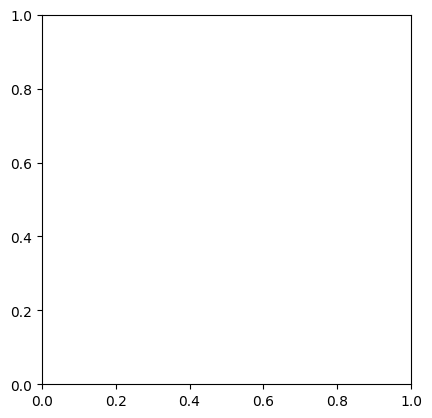

In [19]:
image = reconstructions['brain_test1.h5']
import matplotlib.pyplot as plt
plt.imshow(image[4], cmap='gray')